In [45]:
#Graph Gen 1.1 (27/03/2025)
# Added inputs and outputs
# The power consumption for a node ranges from 1 to 50 units and uniformly distributed.
# Plus the area may vary from 1 to 5 units as well, uniformly distributed
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import random

def generate_netlist(
    num_nodes=50,
    num_edges=100,
    enable_area=True,
    #Area (chip constraints) of the node or the gate assembly
    enable_power=True,
    # Power consumption of the gate (used to optimize or reduce heat generation or power consumption per chip)
    enable_wire_count=True,
    # Number of wires represented by an edge
    enable_distance=True,
    # Distance of the wire to calculate power dissipation and delay
    seed = None
):
    """Generates a netlist as a graph with configurable node & edge attributes."""
    if seed:
        random.seed(seed)
        np.random.seed(seed)

    #Generate a directed graph
    G = nx.DiGraph()

    # Estimate number of inputs and outputs
    # Assuming num_inputs and num_outputs to be the functions below
    num_inputs = math.ceil(math.log2(num_nodes))
    num_outputs = math.ceil(num_inputs / 2)
    input_nodes = [f"IN_{i}" for i in range(num_inputs)]
    output_nodes = [f"OUT_{i}" for i in range(num_outputs)]


    # Create internal nodes
    for i in range(num_nodes):
        node_name = f"N_{i}"
        G.add_node(node_name)

        if enable_area:
            G.nodes[node_name]['area'] = round(random.uniform(1.0, 5.0), 2)
        if enable_power:
            G.nodes[node_name]['power'] = round(random.uniform(1.0, 50.0), 2)

    # Create input and output nodes
    for node in input_nodes + output_nodes:
        G.add_node(node)

    # Ensure the graph is connected using a spanning tree first
    all_nodes = input_nodes + [f"N_{i}" for i in range(num_nodes)]
    random.shuffle(all_nodes)
    for i in range(len(all_nodes) - 1):
        G.add_edge(all_nodes[i], all_nodes[i + 1])
        if enable_wire_count:
            G.edges[all_nodes[i], all_nodes[i + 1]]['wires'] = random.randint(1, 5)
        if enable_distance:
            G.edges[all_nodes[i], all_nodes[i + 1]]['distance'] = round(random.uniform(1.0, 10.0), 2)

    # Add additional random edges while keeping the graph connected
    existing_edges = set(G.edges())
    while len(G.edges()) < num_edges:
        u, v = random.sample(all_nodes, 2)
        if u != v and (u, v) not in existing_edges:
            G.add_edge(u, v)
            existing_edges.add((u, v))
            if enable_wire_count:
                G.edges[u, v]['wires'] = random.randint(1, 5)
            if enable_distance:
                G.edges[u, v]['distance'] = round(random.uniform(1.0, 10.0), 2)

    # Ensure each output node has at least one incoming connection
    for out_node in output_nodes:
        if G.in_degree(out_node) == 0:
            source_node = random.choice(all_nodes)
            G.add_edge(source_node, out_node)
            if enable_wire_count:
                G.edges[source_node, out_node]['wires'] = random.randint(1, 5)
            if enable_distance:
                G.edges[source_node, out_node]['distance'] = round(random.uniform(1.0, 10.0), 2)

    return G, input_nodes, output_nodes

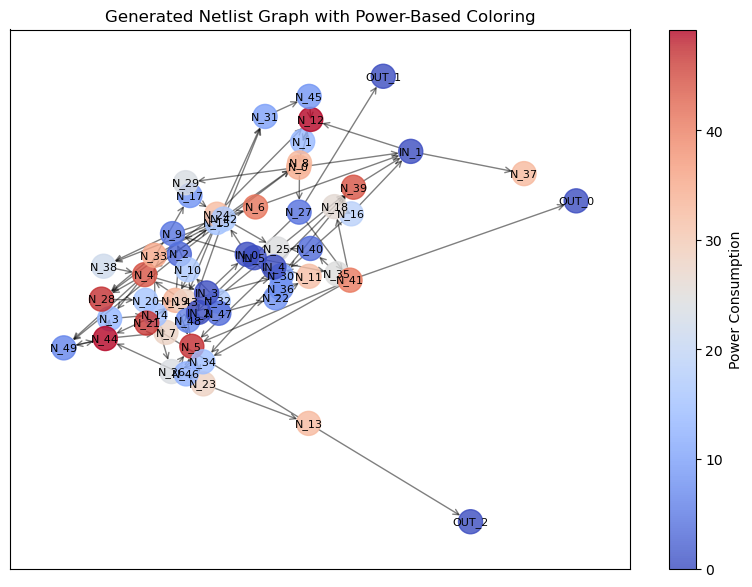

In [46]:
def visualize_netlist(G):
    pos = nx.spring_layout(G, seed=42)
    power_values = [G.nodes[n].get('power', 0) for n in G.nodes()]

    plt.figure(figsize=(10, 7))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=power_values, cmap='coolwarm', alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5, arrowstyle='->', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)

    cbar = plt.colorbar(nodes)
    cbar.set_label("Power Consumption")
    plt.title("Generated Netlist Graph with Power-Based Coloring")
    plt.show()

# Example usage
graph, inputs, outputs = generate_netlist(num_nodes=50, num_edges=100)
visualize_netlist(graph)


In [57]:
import random
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

def calculate_power(G, u, v):
    """Calculate power consumption for an edge."""
    node_power = G.nodes[u].get('power', 0) + G.nodes[v].get('power', 0)
    wire_power = G.edges[u, v].get('distance', 1) * G.edges[u, v].get('wires', 1)
    return node_power + wire_power

def find_critical_path(G):
    """Finds the longest path in the graph using delay = L^2."""
    longest_path = None
    max_delay = 0

    for source in G.nodes():
        for target in G.nodes():
            if source != target and nx.has_path(G, source, target):
                path = nx.shortest_path(G, source, target, weight='distance')
                path_delay = sum(G[u][v]['distance'] ** 2 for u, v in zip(path, path[1:]))
                if path_delay > max_delay:
                    max_delay = path_delay
                    longest_path = path

    return longest_path, max_delay

def perform_agglomerative_clustering(G, num_clusters=5):
    """Clusters the netlist using Agglomerative Clustering while optimizing constraints."""
    node_features = []
    node_names = []
    for node in G.nodes():
        power = G.nodes[node].get('power', 0)
        area = G.nodes[node].get('area', 0)
        node_features.append([power, area])
        node_names.append(node)
    
    node_features = np.array(node_features)
    linkage_matrix = linkage(pdist(node_features), method='complete')
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    cluster_dict = {node_names[i]: clusters[i] for i in range(len(node_names))}
    nx.set_node_attributes(G, cluster_dict, 'cluster')
    
    return G, cluster_dict

def calculate_wire_cut_and_length(G, cluster_dict):
    """Calculates edge cuts and total wire length based on clusters."""
    edge_cuts, total_wire_length = 0, 0
    scaling_factor = 10

    for u, v, data in G.edges(data=True):
        wire_length = data.get('distance', 1)
        if cluster_dict.get(u) == cluster_dict.get(v):  # Intra-cluster
            total_wire_length += wire_length
        else:  # Inter-cluster
            total_wire_length += scaling_factor * wire_length
            edge_cuts += 1

    return edge_cuts, total_wire_length

def visualize_clusters(G, cluster_dict):
    """Visualizes the netlist graph with color-coded clusters."""
    pos = nx.spring_layout(G, seed=42)
    cluster_colors = [cluster_dict.get(node, 0) for node in G.nodes()]
    
    plt.figure(figsize=(10, 7))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=cluster_colors, cmap='tab10', alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5, arrowstyle='->', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)

    cbar = plt.colorbar(nodes)
    cbar.set_label("Cluster ID")
    plt.title("Netlist Graph with Clustering")
    plt.show()

Number of Edge Cuts: 77
Total Wire Length: 4666.259999999999
Critical Path Before Scaling: ['N_33', 'N_27', 'N_0', 'N_20', 'N_47', 'N_39', 'IN_4', 'N_35', 'N_4', 'N_44', 'N_2', 'N_17', 'N_38', 'N_24', 'N_37', 'N_48', 'IN_0', 'N_23', 'N_45']
Critical Path Delay Before Scaling: 759.6591
Critical Path After Scaling: ['N_7', 'IN_2', 'N_47', 'N_42', 'N_41', 'N_46', 'N_19', 'N_40', 'N_6', 'N_18', 'N_32', 'N_3', 'N_29', 'N_13', 'IN_1', 'N_26', 'N_33', 'N_27']
Critical Path Delay After Scaling: 72082.12640000001


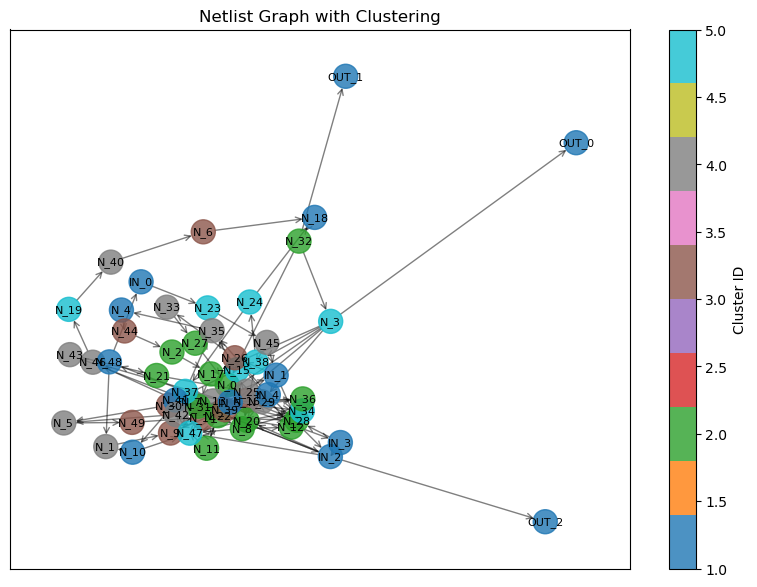

In [58]:
# Generate the netlist graph
graph, inputs, outputs = generate_netlist(num_nodes=50, num_edges=100)

# Perform clustering and get the cluster mapping
graph, cluster_dict = perform_agglomerative_clustering(graph)

# Compute edge cuts and wire length
edge_cuts, total_wire_length = calculate_wire_cut_and_length(graph, cluster_dict)

# Compute critical path before scaling
critical_path_before, delay_before = find_critical_path(graph)

# Update distances for inter-cluster edges
for u, v in graph.edges():
    if cluster_dict.get(u) != cluster_dict.get(v):
        graph[u][v]['distance'] *= 10

# Compute critical path after scaling
critical_path_after, delay_after = find_critical_path(graph)

# Print results
print(f"Number of Edge Cuts: {edge_cuts}")
print(f"Total Wire Length: {total_wire_length}")
print(f"Critical Path Before Scaling: {critical_path_before}")
print(f"Critical Path Delay Before Scaling: {delay_before}")
print(f"Critical Path After Scaling: {critical_path_after}")
print(f"Critical Path Delay After Scaling: {delay_after}")

# Visualize the clusters
visualize_clusters(graph, cluster_dict)